In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm import tqdm
import itertools

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
mlp_units = 128
embedding_dim = 128



In [2]:
drive.mount("/content/gdrive/")

MessageError: Error: credential propagation was unsuccessful

In [2]:
 !unzip '/content/gdrive/My Drive/archive (3).zip'

Archive:  /content/gdrive/My Drive/archive (3).zip
  inflating: ratings_Beauty.csv      


In [3]:

data  = pd.read_csv('/content/ratings_Beauty.csv')
data = data[['UserId', 'ProductId', 'Rating']]
users = data['UserId'].unique()
len(users)

1210271

In [4]:
N = 2
number_of_users_tokens = 1108
elements = range(1, number_of_users_tokens)
lists = [elements] * N
combinations = list(itertools.product(*lists))
combinations_of_users = [np.array(list(combo)) for combo in combinations]
combinations_of_users = np.array(combinations_of_users[:len(users)])
user_id_to_index = {userId: token for token, userId in tqdm(zip(combinations_of_users,users))}
data['NewUserId'] = data['UserId'].map(user_id_to_index)
data.iloc[:, 0] = data['NewUserId']
data.drop(columns=['NewUserId'], inplace=True)
products = data['ProductId'].unique()
p=len(products)
N = 2
number_of_products_tokens = 720
elements = range(1, number_of_products_tokens)
lists = [elements] * N
combinations = list(itertools.product(*lists))
combinations_of_products = [list(combo) for combo in combinations]
combinations_of_products = combinations_of_products[:p]
product_id_to_index = {productId: token for token, productId in tqdm(zip(combinations_of_products,products))}
data['NewproductId'] = data['ProductId'].map(product_id_to_index)
data.iloc[:, 1] = data['NewproductId']
data.drop(columns=['NewproductId'], inplace=True)

1210271it [00:00, 1269944.69it/s]
249274it [00:00, 1395911.77it/s]


In [5]:
data.isna().any()

,0
UserId,False
ProductId,False
Rating,False


In [7]:
X = data[['UserId','ProductId']].to_numpy()
y = np.where(data['Rating'].to_numpy() > 3, 1, 0).astype(np.int32)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=10000)

In [9]:
X_train_user = X_train[:,0]
X_test_user = X_test[:,0]
X_train_item = X_train[:,1]
X_test_item = X_test[:,1]
del X_train, X_test, X, y

In [10]:
X_train_user = np.array([arr for arr in X_train_user])
X_test_user = np.array([arr for arr in X_test_user])
X_train_item = np.array([arr for arr in X_train_item])
X_test_item = np.array([arr for arr in X_test_item])

In [11]:
user_shape = N
item_shape = N
num_user_tokens = number_of_users_tokens
num_item_tokens = number_of_products_tokens

In [15]:
def create_mlp_model():
    user_input = Input(shape=(user_shape,), name='user_input')
    item_input = Input(shape=(item_shape,), name='item_input')

    user_embedding = Embedding(input_dim=num_user_tokens, output_dim=embedding_dim, name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_item_tokens, output_dim=embedding_dim, name='item_embedding')(item_input)

    mlp_branch = tf.keras.layers.Concatenate()([Flatten()(user_embedding), Flatten()(item_embedding)])
    mlp_branch = Dense(mlp_units, activation='relu')(mlp_branch)
    mlp_branch = Dense(128, activation='relu')(mlp_branch)
    mlp_branch = Dense(64, activation='relu')(mlp_branch)
    mlp_output = Dense(1, activation='sigmoid')(mlp_branch)  # Binary output

    mlp_model = Model(inputs=[user_input, item_input], outputs=mlp_output)
    mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return mlp_model

In [26]:
mlp_model = create_mlp_model()

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [27]:
with tf.device('/device:gpu:0'):
  mlp_model.fit((X_train_user,X_train_item),y_train, batch_size  = 10000, epochs = 100, validation_data=((X_test_user,X_test_item),y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7590 - loss: 0.5702 - val_accuracy: 0.7702 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7692 - loss: 0.5333 - val_accuracy: 0.7702 - val_loss: 0.5315 - learning_rate: 0.0010
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7690 - loss: 0.5268 - val_accuracy: 0.7704 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7705 - loss: 0.5148 - val_accuracy: 0.7707 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7744 - loss: 0.5005 - val_accuracy: 0.7700 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7788 - loss: 0.4820 - val_accuracy: 0.7624 - val_loss: 0.5443 - learning_rate: 2.0000e-04


In [31]:
def predictions(user_data, item_data):

    mlp_preds = mlp_model.predict([user_data, item_data])

    return  mlp_preds

# Predictions
mlp_preds = predictions(X_test_user,X_test_item)


mlp_predictions = (mlp_preds > 0.5).astype(int)


18967/18967 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step


In [32]:
precision = precision_score(y_test, mlp_predictions)
recall = recall_score(y_test, mlp_predictions)
f1 = f1_score(y_test, mlp_predictions)

# Calculate regression error metrics
mse = mean_squared_error(y_test, mlp_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, mlp_predictions)

# Output metrics
print(f'MLP Precision: {precision:.4f}')
print(f'MLP Recall: {recall:.4f}')
print(f'MLP F1-Score: {f1:.4f}')
print(f'MLP MSE: {mse:.4f}')
print(f'MLP RMSE: {rmse:.4f}')
print(f'MLP MAE: {mae:.4f}')

MLP Precision: 0.7706
MLP Recall: 0.9996
MLP F1-Score: 0.8702
MLP MSE: 0.2296
MLP RMSE: 0.4791
MLP MAE: 0.2296


In [35]:
def quantization(model, user_data,item_data,relevent_items, X_test_item, X_test_user, y_test, quantization_factor = 8):
  Q = create_mlp_model()
  Q.set_weights(model.get_weights())
  for i in range(len(model.weights)):
    Q.weights[i].assign(tf.math.round(Q.weights[i] * quantization_factor) / quantization_factor)
    Q.layers[i].trainable = False
    with tf.device('/device:gpu:0'):
      Q.fit((user_data,item_data),relevent_items, batch_size  = 10000, epochs = 100, validation_data=((X_test_user,X_test_item),y_test), callbacks=[early_stopping, reduce_lr])
  return Q


In [44]:
for i in range(len(mlp_model.weights)):
  min = np.min( mlp_model.weights[i])
  max = np.max(mlp_model.weights[i])
  print("min: ",min,"\nmax: ", max)


min:  -0.15647058 
max:  0.15666014
min:  -0.18618806 
max:  0.20394401
min:  -0.21875727 
max:  0.22865771
min:  -0.07082958 
max:  0.006656631
min:  -0.21419908 
max:  0.299913
min:  -0.07202435 
max:  0.020231284
min:  -0.24534576 
max:  0.32019803
min:  -0.055018086 
max:  0.006846351
min:  -0.29473174 
max:  0.4332912
min:  0.0071027293 
max:  0.0071027293


In [45]:
Q = quantization(mlp_model,X_train_user,X_train_item,y_train, X_test_user, X_test_item, y_test)

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7701 - loss: 0.5183 - val_accuracy: 0.7695 - val_loss: 0.5551 - learning_rate: 0.0010
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7731 - loss: 0.5043 - val_accuracy: 0.7642 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7776 - loss: 0.4916 - val_accuracy: 0.7485 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7708 - loss: 0.5124 - val_accuracy: 0.7665 - val_loss: 0.5606 - learning_rate: 2.0000e-04
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7733 - loss: 0.5036 - val_accuracy: 0.7604 - val_loss: 0.5672 - learning_rate: 2.0000e-04
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7747 - loss: 0.4985 - val_accuracy: 0.7517 - val_loss: 0.5742 - learning_rate: 2.0000e-04
Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.77

In [47]:
def quantized_model_predictions(user_data, item_data):

    mlp_preds = Q.predict([user_data, item_data])

    return  mlp_preds

# Predictions
mlp_preds = quantized_model_predictions(X_test_user,X_test_item)


mlp_predictions = (mlp_preds > 0.5).astype(int)

18967/18967 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step


In [48]:
precision = precision_score(y_test, mlp_predictions)
recall = recall_score(y_test, mlp_predictions)
f1 = f1_score(y_test, mlp_predictions)

# Calculate regression error metrics
mse = mean_squared_error(y_test, mlp_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, mlp_predictions)

# Output metrics
print(f'Quantized MLP Precision: {precision:.4f}')
print(f'Quantized MLP Recall: {recall:.4f}')
print(f'Quantized MLP F1-Score: {f1:.4f}')
print(f'Quantized MLP MSE: {mse:.4f}')
print(f'Quantized MLP RMSE: {rmse:.4f}')
print(f'Quantized MLP MAE: {mae:.4f}')

Quantized MLP Precision: 0.7776
Quantized MLP Recall: 0.9785
Quantized MLP F1-Score: 0.8666
Quantized MLP MSE: 0.2321
Quantized MLP RMSE: 0.4818
Quantized MLP MAE: 0.2321


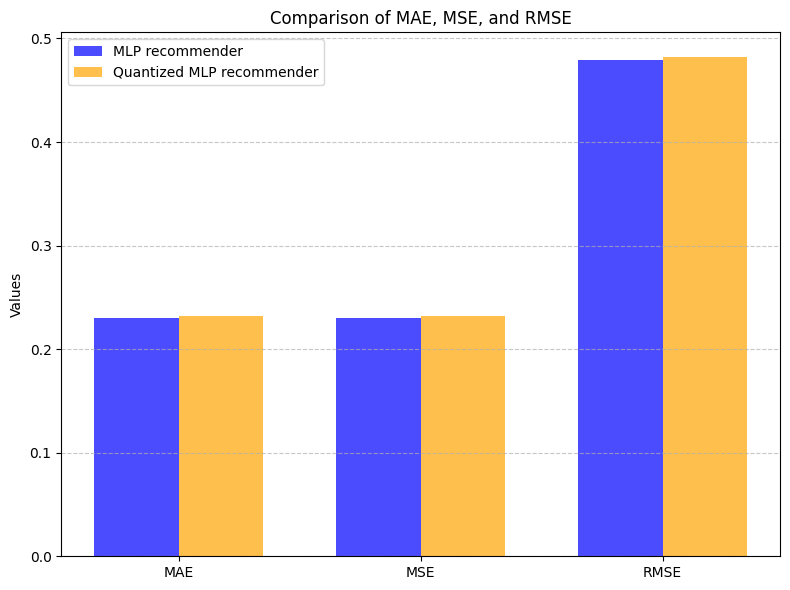

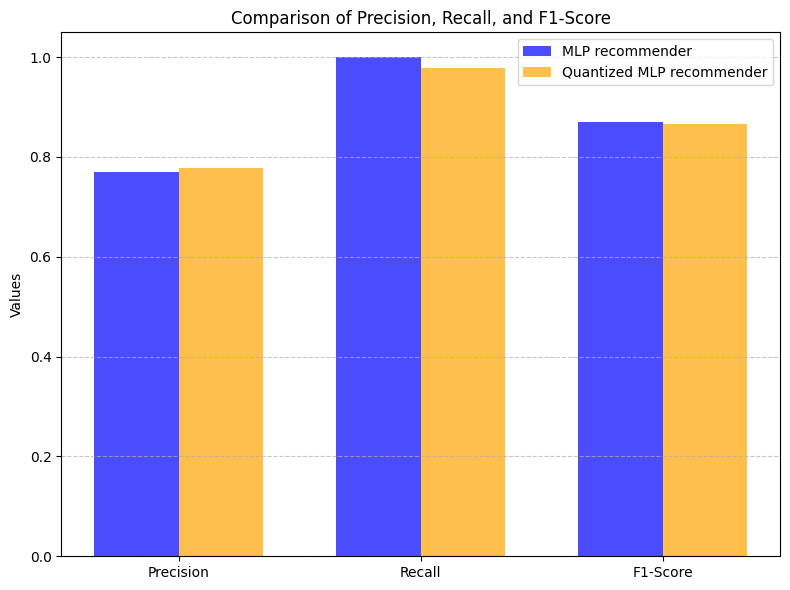

In [4]:
import matplotlib.pyplot as plt



metrics_1 = ['MAE', 'MSE', 'RMSE']
mlp_values_1 = [0.2296, 0.2296, 0.4791]
quantized_values_1 = [0.2321, 0.2321, 0.4818]

metrics_2 = ['Precision', 'Recall', 'F1-Score']
mlp_values_2 = [0.7706, 0.9996, 0.8702]
quantized_values_2 = [0.7776, 0.9785, 0.8666]


x1 = np.arange(len(metrics_1))
x2 = np.arange(len(metrics_2))
bar_width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x1 - bar_width / 2, mlp_values_1, bar_width, label='MLP recommender', color='blue', alpha=0.7)
plt.bar(x1 + bar_width / 2, quantized_values_1, bar_width, label='Quantized MLP recommender', color='orange', alpha=0.7)
plt.xticks(x1, metrics_1)
plt.ylabel('Values')
plt.title('Comparison of MAE, MSE, and RMSE')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/content/Comparison_MAE_MSE_RMSE.png')


plt.figure(figsize=(8, 6))
plt.bar(x2 - bar_width / 2, mlp_values_2, bar_width, label='MLP recommender', color='blue', alpha=0.7)
plt.bar(x2 + bar_width / 2, quantized_values_2, bar_width, label='Quantized MLP recommender', color='orange', alpha=0.7)
plt.xticks(x2, metrics_2)
plt.ylabel('Values')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('/content/Comparison_Precision_Recall_F1Score.png')
plt.show()
